# Plot time-varying power across all subjects

Here, we aggregate LFP data across all subjects and plot average peri-event power in each frequency band.

In [1]:
import pandas as pd
import numpy as np
import physutils
import dbio
import os
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

plt.style.use('ggplot')

In [2]:
# set up relevant parameters
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']  # which bands to limit to
Tpre = -5  # time before event to grab
Tpre_plot = -2.5  # time before event to plot
Tpost = 1.5  # time after event to grab
Tpre_s = -1  # time before starts to grab
Tpost_s = 5  # time after starts to grab
Tpost_plot = 3 # time after start to plot
smwid = 0.2  # smoothing window (in s)

## Define some useful functions

In [3]:
def load_and_preprocess(dtup):
    """
    Load and preprocess LFP data.
    """
    # load data
    lfp = dbio.fetch_all_such_LFP(dbname, *dtup)
    
    # remove global mean
    if lfp.shape[1] > 1:
        lfp = lfp.demean_global()

    # bandpass filter
    lfpraw = physutils.LFPset(lfp.copy(), meta=lfp.meta.copy())
    if bands:
        if lfp.meta['sr'] != 200:
            # decimation is not going to work correctly,
            # so don't include dataset
            return None, None
        
        if lfp.meta['sr'] < 160:  # that is, if we've not sampled fast enough for gamma
            bands.pop()
        lfp = lfp.bandlimit(bands)

    # decimate to 40 Hz
    lfp = lfp.decimate(5)
    lfpraw = lfpraw.decimate(5)

    # instantaneous power
    lfp = lfp.instpwr()
    lfpraw = lfpraw.instpwr()

    # censor
    lfp = lfp.censor()
    lfpraw = lfpraw.censor()
    
    return lfp, lfpraw

In [4]:
def get_peri_event_df(lfp, events, Tpre, Tpost):
    split = lfp.evtsplit(events, Tpre, Tpost)
    logged = physutils.LFPset(np.log(split), meta=lfp.meta.copy())
    means = logged.groupby(level=1).median()
    df = physutils.LFPset(means, meta=lfp.meta.copy())

    return df.smooth(smwid)

In [5]:
def get_normalizers(df):
    """
    Get robust normalizers for data.
    """
    rstd = lambda x: (x - x.median()).abs().median() * 1.4826
    md = df.median()
    return md, rstd

In [6]:
def plot_bands(broad, filtered, evtname, legend=True):
    """
    plot broadband signal and bandpass filtered signal means together
    """
    # zscore channels for plotting
    filt = filtered.rzscore()
    broadband_series = broad.rzscore().mean(axis=1)
    
    broadband_series.name = 'Broadband'
    series_list = [broadband_series]
    
    if bands:
        for bb in bands:
            to_grab = [col for col in filt.columns if bb in col]
            this_df = filt.loc[:, to_grab].mean(axis=1)
            this_df.name = bb.capitalize()
            series_list.append(this_df)
    mean_df = pd.concat(series_list, axis=1)
    mean_df.plot(linewidth=2.0, legend=legend);
    plt.xlim([Tpre_plot, Tpost])
    plt.xlabel('Time (s)')
    plt.ylabel('log(Power) (z-score)')
    plt.title("Mean power across channels");

    # decorations
    plt.axvline(x=0, color='k', zorder=1)
    plt.text(0.05, plt.ylim()[0] + 0.25, evtname, fontweight='bold')
    plt.tick_params(axis='x', which='both', top='off');
    #plt.text(plt.xlim()[1] - 1, plt.ylim()[1] - 0.25, "Dataset {}".format(str(dtup)))

    # place the legend to the right of the plot
    ax = plt.gca();
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2,0.75))
    
    return ax

## Basic setup

In [7]:
# data location
dbname = 'data/bart.hdf5'

In [8]:
# get list of (patient, dataset) tuples to plot
dsets = pd.read_csv('data/lfp_channel_file.csv', header=None).iloc[:, :2].drop_duplicates()

## Loop over datasets

In [9]:
# initialize lists of stop and pop dataframes for bandlimited
# and broadband power
stop_list = []
start_list = []
pop_list = []
stop_list_bb = []
start_list_bb = []
pop_list_bb = []

for row in dsets.itertuples():
    dtup = row[1:]
    print(dtup)

    lfp, lfpraw = load_and_preprocess(dtup)
    
    if lfp is None:
        continue

    # get events
    evt = dbio.fetch(dbname, 'events', *dtup)
    stops = evt['banked'].dropna()
    pops = evt['popped'].dropna()
    starts = evt['start inflating']
    if 'is_control' in evt.columns:
        stops_free = evt.query('is_control == False')['banked'].dropna()
        stops_control = evt.query('is_control == True')['banked'].dropna()
        stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
        stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
    else:
        stops_free = stops
        stops_rewarded = stops
        
    stop_df = get_peri_event_df(lfp, stops_free, Tpre, Tpost)
    start_df = get_peri_event_df(lfp, starts, Tpre_s, Tpost_s)
    pop_df = get_peri_event_df(lfp, pops, Tpre, Tpost)
    raw_stop_df = get_peri_event_df(lfpraw, stops_free, Tpre, Tpost)
    raw_start_df = get_peri_event_df(lfpraw, starts, Tpre_s, Tpost_s)
    raw_pop_df = get_peri_event_df(lfpraw, pops, Tpre, Tpost)
    
    stop_list.append(stop_df.dataframe)
    pop_list.append(pop_df.dataframe)
    start_list.append(start_df.dataframe)
    stop_list_bb.append(raw_stop_df.dataframe)
    pop_list_bb.append(raw_pop_df.dataframe)
    start_list_bb.append(raw_start_df.dataframe)

(11, 1)
(12, 1)
(14, 1)
(14, 2)
(15, 1)
(16, 1)
(16, 2)
(17, 1)
(17, 2)
(18, 1)
(20, 1)
(21, 1)
(22, 1)
(23, 1)
(24, 1)
(25, 1)
(30, 1)


## Concatenate columnwise to form aggregate dataframes

In [10]:
stops = physutils.LFPset(pd.concat(stop_list, axis=1))
starts = physutils.LFPset(pd.concat(start_list, axis=1))
pops = physutils.LFPset(pd.concat(pop_list, axis=1))
stops_bb = physutils.LFPset(pd.concat(stop_list_bb, axis=1))
starts_bb = physutils.LFPset(pd.concat(start_list_bb, axis=1))
pops_bb = physutils.LFPset(pd.concat(pop_list_bb, axis=1))

## Make plots

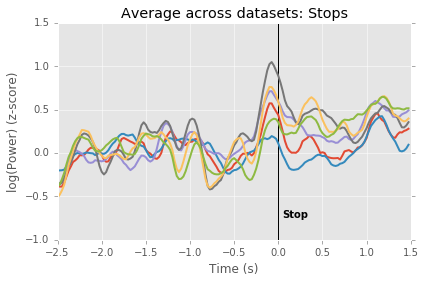

In [11]:
plot_bands(stops_bb, stops, 'Stop', legend=False);
plt.title("Average across datasets: Stops");

plt.tight_layout()

plt.savefig("figures/avg_across_subjs_stops.svg")

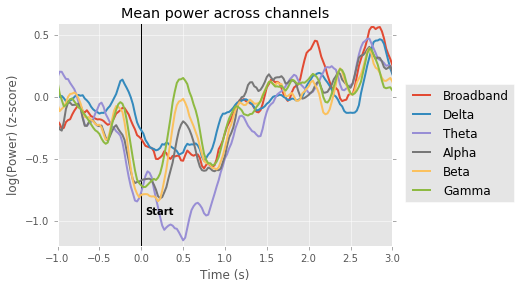

In [12]:
plot_bands(starts_bb, starts, 'Start');
plt.xlim([Tpre_s, Tpost_plot]);

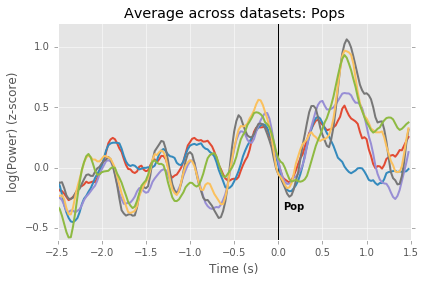

In [13]:
plot_bands(pops_bb, pops, 'Pop', legend=False);
plt.title("Average across datasets: Pops");

plt.tight_layout()

plt.savefig("figures/avg_across_subjs_pops.svg")

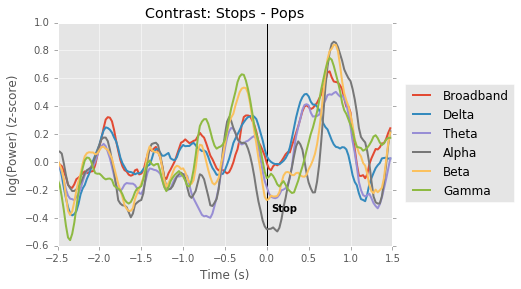

In [14]:
diff_bb = physutils.LFPset(stops_bb.dataframe / pops_bb.dataframe)
diff_filt = physutils.LFPset(stops.dataframe / pops.dataframe)
plot_bands(diff_bb, diff_filt, 'Stop')
plt.title("Contrast: Stops - Pops");